In [140]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt

## 1. Линейная регрессия. Реализация

In [141]:
data = load_boston()
data['data'].shape

C:\PythonProject\skillfactory мат анализ\.venv1\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this case special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the 

(506, 13)

In [142]:
print(data['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

### 1.1. Реализация линейной регрессии с использованием матричных операций

Линейная регрессия выражается следующей зависимостью:
$$y=X\theta+\epsilon,$$
где $X$ — матрица объекты-признаки, $y$ — вектор целевых значений, соответствующих $X$, $\theta$ — параметр линейной регрессии, $\epsilon$ — некоторый шум.

Из данного следует выражение для $\theta$ как:
$$X^Ty=X^TX\theta \rightarrow \theta=(X^TX)^{-1}X^Ty$$

Реализуем выражение для $\theta$ с помощью операций линейной алгебры библиотеки Numpy:

In [143]:
# ЗАДАЧА Реализовать функцию, осуществляющую матричные операции для получения theta
def linreg_linear(X, y):
    theta = np.linalg.inv(X.transpose().dot(X)).dot(X.transpose()).dot(y)
    return theta

In [144]:
# Подготовить данные

X, y = data['data'], data['target']
X = np.hstack([np.ones(X.shape[0])[:, np.newaxis], X])

In [145]:
# Вычислить параметр theta
theta = linreg_linear(X, y)
theta

array([ 3.64594884e+01, -1.08011358e-01,  4.64204584e-02,  2.05586264e-02,
        2.68673382e+00, -1.77666112e+01,  3.80986521e+00,  6.92224640e-04,
       -1.47556685e+00,  3.06049479e-01, -1.23345939e-02, -9.52747232e-01,
        9.31168327e-03, -5.24758378e-01])

In [146]:
theta.shape

(14,)

In [147]:
# Сделать предсказания для тренировочной выборки
y_pred = X.dot(theta)

In [148]:
def print_regression_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f'MSE = {mse:.2f}, RMSE = {rmse:.3f}')

In [149]:
# Посчитать значение ошибок MSE и RMSE для тренировочных данных
print_regression_metrics(y, y_pred)

MSE = 21.89, RMSE = 4.679


In [150]:
a = (2 * 2)**(-1)
b = (2**(-1) * 2**(-1))

print(a)
print(b)

0.25
0.25


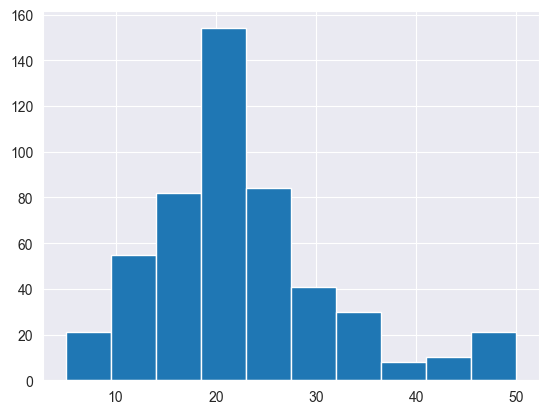

In [151]:
plt.hist(y);

In [152]:
# Разбить выборку на train/valid, вычислить theta,
# сделать предсказания и посчитать ошибки MSE и RMSE

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)
theta = linreg_linear(X_train, y_train)
y_pred = X_valid.dot(theta)
y_train_pred = X_train.dot(theta)

In [153]:
print_regression_metrics(y_valid, y_pred)
print_regression_metrics(y_train, y_train_pred)

MSE = 17.32, RMSE = 4.162
MSE = 23.29, RMSE = 4.826


In [154]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X,y)
y_pred = lr.predict(X)
print_regression_metrics(y, y_pred)

MSE = 21.89, RMSE = 4.679


### 1.2. Реализация линейной регрессии с использованием методов оптимизации

Для реализации линейной регрессии с помощью методов оптимизации будем использовать функцию ошибки **среднего квадратичного** ([Mean Squared Error](https://en.wikipedia.org/wiki/Mean_squared_error)), которая является выпуклой функцией в n-мерном пространстве $\mathbb{R}^n$ и в общем виде выглядит следующим образом:
$$MSE = \frac{1}{n} * \sum_{i=1}^{n}{(y_i - a(x_i))^2}.$$
Здесь $x_i$ — вектор-признак $i$-го объекта обучающей выборки, $y_i$ — истинное значение для $i$-го объекта, $a(x)$ — алгоритм, предсказывающий для данного объекта $x$ целевое значение, $n$ — кол-во объектов в выборке.

В случае линейной регрессии $MSE$ представляется как:
$$MSE(X, y, \theta) = \frac{1}{2n} * \sum_{i=1}^{n}{(y_i - \theta^Tx_i)^2} = \frac{1}{2n} \lVert{y - X\theta}\rVert_{2}^{2}=\frac{1}{2n} (y - X\theta)^T(y - X\theta),$$
где $\theta$ — параметр модели линейной регрессии, $X$ — матрица объекты-признаки, $y$ - вектор истинных значений, соответствующих $X$.

Возьмем первый вариант представления функции ошибки и посчитаем ее градиент по параметру $\theta$, предварительно переименовав $MSE$ в $L$:
$$L=\frac{1}{2n} * \sum_{i=1}^{n}{(y_i - \theta^Tx_i)^2}$$
$$\nabla L = \frac{1}{n}\sum_{i=1}^{n}{(\theta^Tx_i - y_i) \cdot x_i} = \frac{1}{n}X^T(X\theta - y)$$

Исходя из полученного выражения градиента, реализуем алгоритм градиентного спуска:

In [155]:
# Реализовать функцию вычисления градиента функции MSE

def calc_mse_gradient(X, y, theta):
    n = X.shape[0]
    grad = 1. / n * X.transpose().dot(X.dot(theta) - y)
    
    return grad

In [156]:
# Реализовать функцию, осуществляющую градиентный шаг
# (функция должна содержать параметр величины шага alpha - learning rate)

def gradient_step(theta, theta_grad, alpha):
    return theta - alpha * theta_grad

In [157]:
# Реализовать функцию цикла градиентного спуска с доп. параметрами
# начального вектора theta и числа итераций

def optimize(X, y, grad_func, start_theta, alpha, n_iters):
    theta = start_theta.copy()
    
    for i in range(n_iters):
        theta_grad = grad_func(X, y, theta)
        theta = gradient_step(theta, theta_grad, alpha)
    
    return theta


In [158]:
# Разбить таблицу данных на матрицы X и y
X, y = data['data'], data['target']

# Добавить фиктивный столбец единиц (bias линейной модели)
X = np.hstack([np.ones(X.shape[0])[:, np.newaxis], X])
m = X.shape[1]

In [159]:
# Оптимизировать параметр линейной регрессии theta на всех данных
theta = optimize(X, y, calc_mse_gradient, np.ones(m), 0.001, 100)

In [160]:
theta

array([7.41647399e+246, 3.32349992e+247, 7.39564172e+247, 8.96295209e+247,
       5.07578059e+245, 4.22030567e+246, 4.63094053e+247, 5.29083888e+248,
       2.65643383e+247, 8.19991211e+247, 3.27135991e+249, 1.38363846e+248,
       2.64323053e+249, 9.88835598e+247])

In [161]:
# Проверить максимальные значения по каждому признаку в данных
X.max(axis=0)

array([  1.    ,  88.9762, 100.    ,  27.74  ,   1.    ,   0.871 ,
         8.78  , 100.    ,  12.1265,  24.    , 711.    ,  22.    ,
       396.9   ,  37.97  ])

In [162]:
print(data['feature_names'][np.argmax(X.std(axis=0)) + 1])
print(np.max(X.std(axis=0)))

B
168.3704950393814


In [163]:
# Нормализовать даннные с помощью стандартной нормализации
X, y = data['data'], data['target']
X = (X - X.mean(axis=0)) / X.std(axis=0)

In [164]:
# Добавить фиктивный столбец единиц (bias линейной модели)
X = np.hstack([np.ones(X.shape[0])[:, np.newaxis], X])
X.max(axis=0)

array([1.        , 9.9339306 , 3.80423444, 2.42256516, 3.66839786,
       2.73234648, 3.55504427, 1.11749449, 3.96051769, 1.66124525,
       1.79819419, 1.63882832, 0.44105193, 3.54877081])

In [165]:
# Оптимизировать theta на новых данных
theta = optimize(X, y, calc_mse_gradient, np.ones(m), 0.01, 5000)

In [166]:
theta

array([ 2.25328063e+01, -9.21740195e-01,  1.07033639e+00,  1.06388396e-01,
        6.86667316e-01, -2.05006416e+00,  2.68062168e+00,  1.40667969e-02,
       -3.10608483e+00,  2.57511475e+00, -1.97802851e+00, -2.05725099e+00,
        8.48690321e-01, -3.74025884e+00])

In [167]:
# Сделать предсказания при полученных параметрах
y_pred = X.dot(theta)

In [168]:
# Посчитать значение ошибок MSE и RMSE для тренировочных данных
print_regression_metrics(y, y_pred)

MSE = 21.90, RMSE = 4.679


In [169]:
# Разбить выборку на train/valid, оптимизировать theta,
# сделать предсказания и посчитать ошибки MSE и RMSE

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)
theta = optimize(X_train, y_train, calc_mse_gradient, np.ones(m), 0.01, 5000)
y_pred = X_valid.dot(theta)

print_regression_metrics(y_valid, y_pred)

MSE = 18.00, RMSE = 4.243


# Задание 3.6.3

У какого из признаков наибольшее стандартное отклонение? Чему оно равно?

Ответ округлите до сотых. Пример ввода: 5.55.

In [135]:
data = load_boston()
data['data'].shape

X, y = data['data'], data['target']
#X = np.hstack([np.ones(X.shape[0])[:, np.newaxis], X])

X = X.std(axis=0)

X.max(axis=0)


168.3704950393814

# Задание 3.6.4

Обучите регрессию без дополнительного столбца единиц. Какой получился RMSE?

Ответ округлите до сотых. Пример ввода: 5.55.

In [139]:
data = load_boston()
data['data'].shape


X, y = data['data'], data['target']

lr.fit(X, y)


y_pred = lr.predict(X)

print_regression_metrics(y, y_pred
                         )


MSE = 21.89, RMSE = 4.679


C:\PythonProject\skillfactory мат анализ\.venv1\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this case special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the 